### Noise calculations for paper revisions


This notebook explores the model training noise as requested during the first round of paper review.

We use the conda environment `analysis`


#### Define some useful functions

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #Ignore SettingWithCopyWarning - we are safe here

def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())

    
    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 
    
    
    
    
    
    return df,df_grouped



def surface_noise_numbers(df):
    
 
    
    print("Numer of grid points:", len(df))
    print("Median variance:", df['variance'].median())
    print("Mean variance:", df['variance'].mean())
    
    print("Median median error:", df['median_error'].median())
    print("Mean mean error:", df['mean_error'].mean())
    
  

    return df['variance'].median()
    
    
    
    
def pipeline(models_to_compare,ID):
    
    annually_averaged_dfs = []
    for m in models_to_compare:
        predictions,predictions_averaged = load_predictions(m)
        annually_averaged_dfs.extend([predictions_averaged])
        
        
        
    change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
    change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
    change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file
    
    
    
    
    #Create a new df that will just hold the differences   

    df =annually_averaged_dfs[0] #pick a df to get latitudes 
    data = { 'latitude_ERA':     df.latitude_ERA, 
             'longitude_ERA':    df.longitude_ERA,
             'MODIS_LST':        df.MODIS_LST,
             'latitude_join':    round(df.latitude_ERA,3), 
             'longitude_join':    round(df.longitude_ERA,3)}


    i = 1
    selected_cols = [] #we will use this later when computing variances
    for df in annually_averaged_dfs:
        data[f'prediction_error_{i}'] = df['model_predicion_error']
        data[f'prediction_{i}'] = df['predictions']

        selected_cols.extend([f'prediction_error_{i}'])
        i = i+1

    df_new = pd.DataFrame(data)  
    
    
    
    #Join and save
    df_cat = pd.merge(df_new,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.
    df_cat = df_cat.drop(['latitude_join', 'longitude_join','latitude_ERA_y', 'longitude_ERA_y'], axis=1) #Get rid of junk columns
    
    
    

        
    df_cat['median_error']=df_cat[selected_cols].median(axis=1) # median over the prediciton errors for each grid point
    df_cat['mean_error']  =df_cat[selected_cols].mean(axis=1)     # mean over the prediciton errors for each grid point
    df_cat['variance']    =df_cat[selected_cols].std(axis=1)        # variance over the prediciton errors for each grid point i.e. noise
    
    df_cat['label'] = ID
    
    
    
    
    
    
    return df_cat
            

In [2]:
import matplotlib.pyplot as plt 

In [3]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'

In [4]:
import warnings
warnings.filterwarnings("ignore") #ignore FutureWarning statements

In [5]:

#V15
model_1 = f'{root}V15_noise_expt_1/'
model_2 = f'{root}V15_noise_expt_2/'
model_3 = f'{root}V15_noise_expt_3/'
model_4 = f'{root}V15_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15 = pipeline(models_to_compare,'V15')


----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.08259364 0.226959228515625 3.8190529346466064
Mean/Median/Std prediction error: 2.9854784 2.280975341796875 2.499044418334961
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.17329945 0.29364013671875 3.8254127502441406
Mean/Median/Std prediction error: 2.9893332 2.27545166015625 2.509122133255005
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0777295 0.20306396484375 3.8673462867736816
Mean/Median/Std prediction error: 3.0292234 2.315216064453125 2.526977300643921
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.06500694 0.195526123046875 3.8166935443878174
Mean/Median/Std prediction error: 2.9783933 2.266021728515625 2.5020196437835693


In [6]:

#V20
model_1 = f'{root}V20_noise_expt_1/'
model_2 = f'{root}V20_noise_expt_2/'
model_3 = f'{root}V20_noise_expt_3/'
model_4 = f'{root}V20_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20 = pipeline(models_to_compare,'V20')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.03033202 0.1646728515625 3.752133846282959
Mean/Median/Std prediction error: 2.9254482 2.22674560546875 2.460106134414673
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: -0.007963768 0.139404296875 3.738788366317749
Mean/Median/Std prediction error: 2.9157598 2.22027587890625 2.4527735710144043
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.007012897 0.1645050048828125 3.75597882270813
Mean/Median/Std prediction error: 2.9231608 2.218292236328125 2.4682388305664062
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09345146 0.24273681640625 3.766803503036499
Mean/Median/Std prediction error: 2.938286 2.23773193359375 2.4697763919830322


In [7]:
#V15X
model_1 = f'{root}V15X_noise_expt_1/'
model_2 = f'{root}V15X_noise_expt_2/'
model_3 = f'{root}V15X_noise_expt_3/'
model_4 = f'{root}V15X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15X = pipeline(models_to_compare,'V15X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.11968606 0.256805419921875 3.8112101554870605
Mean/Median/Std prediction error: 2.9751918 2.26409912109375 2.4991891384124756
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.13466427 0.283203125 3.8165290355682373
Mean/Median/Std prediction error: 2.9872673 2.28326416015625 2.4953765869140625
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.116345696 0.249847412109375 3.7914483547210693
Mean/Median/Std prediction error: 2.9598544 2.255523681640625 2.482562303543091
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.095885955 0.227081298828125 3.8253984451293945
Mean/Median/Std prediction error: 2.9926925 2.285858154296875 2.501439094543457


In [8]:
#V20X
model_1 = f'{root}V20X_noise_expt_1/'
model_2 = f'{root}V20X_noise_expt_2/'
model_3 = f'{root}V20X_noise_expt_3/'
model_4 = f'{root}V20X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20X = pipeline(models_to_compare,'V20X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.027514113 0.176727294921875 3.726653814315796
Mean/Median/Std prediction error: 2.9039862 2.21014404296875 2.4494988918304443
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09134957 0.246063232421875 3.7221148014068604
Mean/Median/Std prediction error: 2.903454 2.2080078125 2.4453623294830322
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0630729 0.195037841796875 3.746485471725464
Mean/Median/Std prediction error: 2.9238696 2.227630615234375 2.4557199478149414
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0765716 0.221038818359375 3.7533504962921143
Mean/Median/Std prediction error: 2.9316843 2.2370452880859375 2.456343412399292


## Categories 

In [9]:
lake_condition        = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant'
lake_ground_condition = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not cvhFr_change_is_significant & not cvlFr_change_is_significant'
vegetation_condition  = 'cvhFr_change_is_significant & not clFr_change_is_significant'
glacier_condition     = 'si10Fr_change_is_significant'


#### LAKES

In [251]:

import numpy as np 


def get_summary_numbers(df):
    prediction_errors = df.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
    return np.mean(prediction_errors), np.std(prediction_errors)


def summary_stats(V15,V15X,V20,V20X):
    
    V15_mean,V15_std   = get_summary_numbers(V15)
    V15X_mean,V15X_std = get_summary_numbers(V15X)
    V20_mean,V20_std   = get_summary_numbers(V20)
    V20X_mean,V20X_std = get_summary_numbers(V20X)
        
    
    delta_v15X =  V15X_mean - V15_mean
    delta_v20  =  V20_mean  - V15_mean
    delta_v20X =  V20X_mean - V15_mean
    
    n_grid_cells = len(V15)
    sig_fig = 6
    print("Summary statistics:", n_grid_cells, "||", round(V15_std,sig_fig),round(V15X_std,sig_fig),round(V20_std,sig_fig),round(V20X_std,sig_fig), "||", round(delta_v15X,sig_fig),round(delta_v20,sig_fig), round(delta_v20X,sig_fig))
    

     
    

In [252]:
#Lakes
df_lake_v15 = df_V15.query(lake_condition)
df_lake_v20 = df_V20.query(lake_condition)
df_lake_v15X = df_V15X.query(lake_condition)
df_lake_v20X = df_V20X.query(lake_condition)
summary_stats(df_lake_v15,df_lake_v15X,df_lake_v20,df_lake_v20X)

Summary statistics: 1631 || 0.074446 0.024075 0.019606 0.01649 || -0.199883 -0.366841 -0.366093


In [207]:
#Lake - ground
df_lake_g_v15 = df_V15.query(lake_ground_condition)
df_lake_g_v20 = df_V20.query(lake_ground_condition)
df_lake_g_v15X = df_V15X.query(lake_ground_condition)
df_lake_g_v20X = df_V20X.query(lake_ground_condition)
summary_stats(df_lake_g_v15,df_lake_g_v15X,df_lake_g_v20,df_lake_g_v20X)

Summary statistics: 546 || 0.15 0.05 0.04 0.06 || -0.56 -0.83 -0.84


In [208]:
#veg
df_veg_v15 = df_V15.query(vegetation_condition)
df_veg_v20 = df_V20.query(vegetation_condition)
df_veg_v15X = df_V15X.query(vegetation_condition)
df_veg_v20X = df_V20X.query(vegetation_condition)
summary_stats(df_veg_v15,df_veg_v15X,df_veg_v20,df_veg_v20X)

Summary statistics: 58 || 0.04 0.1 0.15 0.21 || -0.0 0.04 0.0


In [210]:
#glacier
df_si_v15 = df_V15.query(glacier_condition)
df_si_v20 = df_V20.query(glacier_condition)
df_si_v15X = df_V15X.query(glacier_condition)
df_si_v20X = df_V20X.query(glacier_condition)
summary_stats(df_si_v15,df_si_v15X,df_si_v20,df_si_v20X)

Summary statistics: 1057 || 0.03 0.08 0.02 0.06 || -0.01 -0.22 -0.28


### Couple of representative plots 

In [211]:

from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator




def shift_plot(df1,df2,conditions,names,savefig=None):
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    plt.rcParams["font.family"] = "serif"
    
    
    yticks = np.arange(len(conditions))

    
    
    i = 0
    for c in conditions:
        df1_c = df1.query(c)
        df2_c = df2.query(c)

    
        df1_averaged = df1_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
        df2_averaged = df2_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation

        xi = yticks[len(yticks)-i-1]
       
        for j in range(4):
            ax.scatter(df1_averaged[j],xi,c='C0',label='df1')
            ax.scatter(df2_averaged[j],xi,c='C1',label='df2')
        
    
        i += 1

    
    
    # get the xticks, which are the numeric location of the ticks

    yticklabels = list(map(str, yticks))

    for k in range(len(names)):
        yticklabels[len(yticks)-k-1] = names[k]
        
    _ = ax.set_yticks(yticks, yticklabels)
    


    colors = ['C0', 'C1']
    lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
    labels = ['V15','V20']
    plt.legend(lines, labels)
    
    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)

    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)



    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)


        
        

def dual_histogram_plot(df1,df2,labels,savefig=None):
    
    plt.rcParams["font.family"] = "serif"
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    
    #Histogram of the mean error
    df1['mean_error'].hist(bins=100,ax=ax,label=labels[0])

    #Histogram of the mean error
    df2['mean_error'].hist(bins=100,ax=ax,label=labels[1])

    ax.legend()
    ax.grid(False)
   

    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)
    
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)

    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)
    
    plt.show()
        
        
        

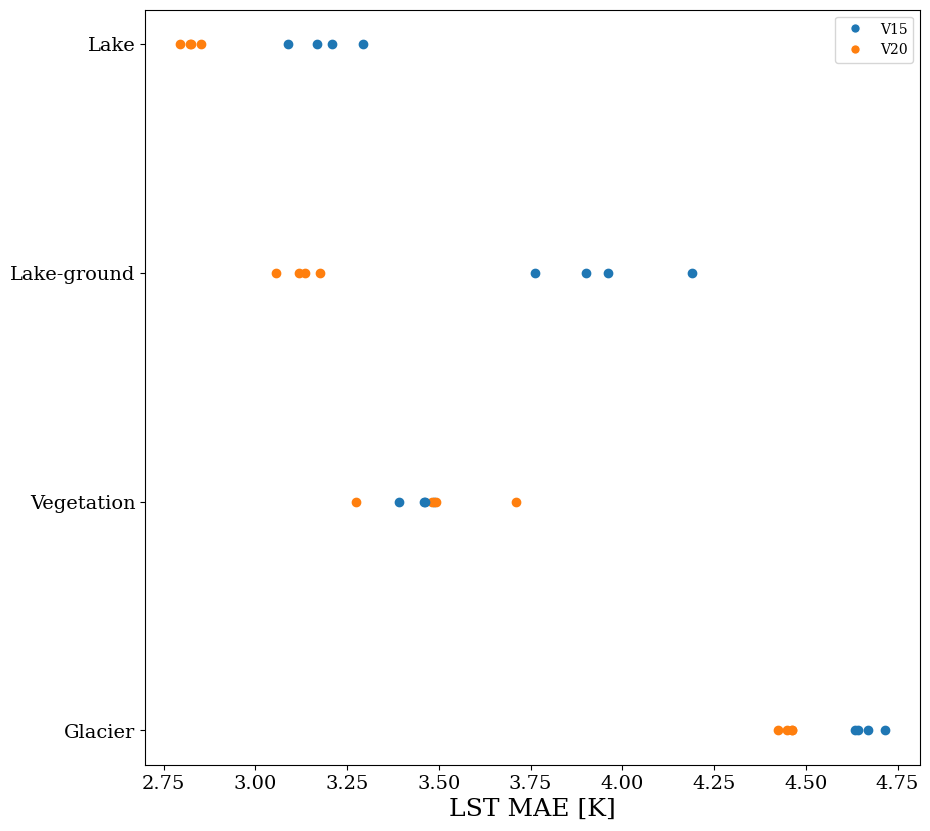

In [212]:
conditions = [lake_condition,lake_ground_condition,vegetation_condition,glacier_condition]
names = ["Lake", "Lake-ground", "Vegetation", "Glacier"]
shift_plot(df_V15,df_V20,conditions,names,savefig="global_shift_plot")

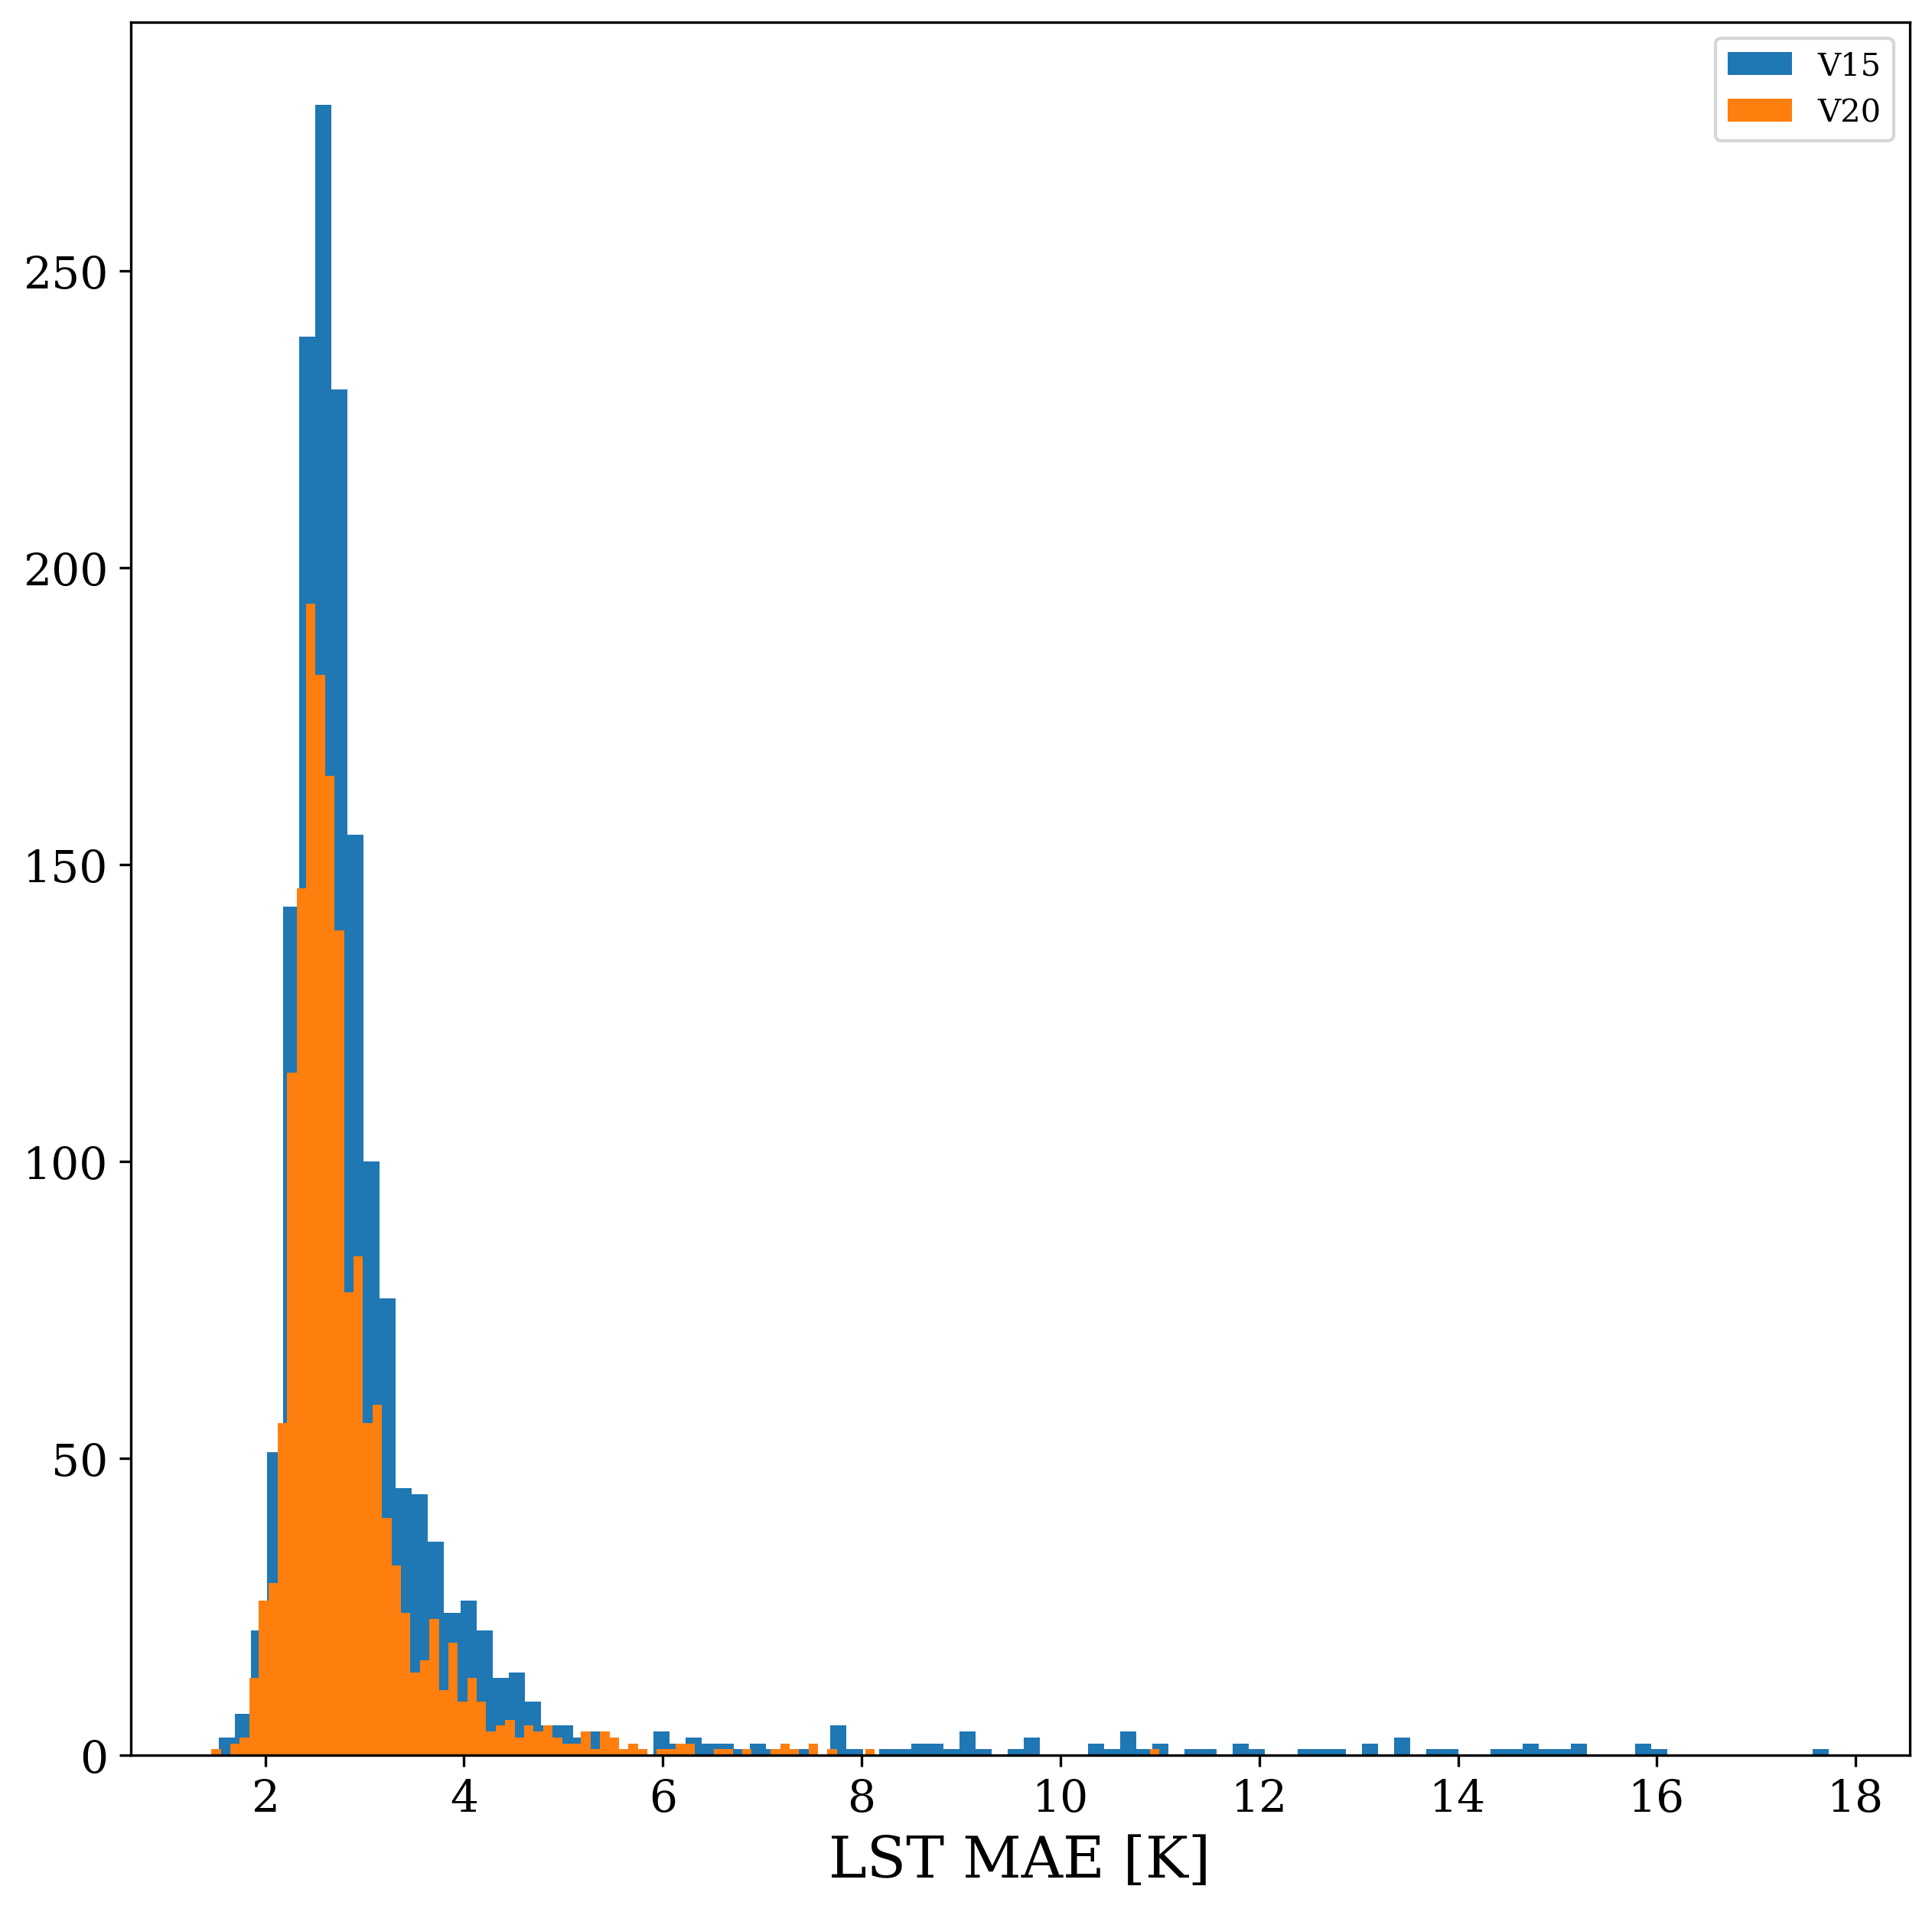

In [146]:
dual_histogram_plot(df_V15.query(lake_condition),df_V20.query(lake_condition),["V15", "V20"],savefig="lakes_histogram_plot")

#### Deep dive on individual bad points

In [213]:
lake_natron_condition                = 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0000'
lake_natron_northern_edge_condition  = 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0000'
lake_blanche_condition               ='latitude_ERA ==  -29.367671674745356 & longitude_ERA == 139.6875'
salt_lake_city_condition             ='latitude_ERA ==  41.17094491970063 & longitude_ERA ==  -113.39999999999998'
farah_province_condition             ='latitude_ERA ==  31.615914311651938 & longitude_ERA == 61.120000000000005'
gujarat_province_condition           ='latitude_ERA ==  24.028095261448925 & longitude_ERA ==  69.0'
toshka_lakes_condition               ='latitude_ERA ==  23.18500423251539 & longitude_ERA ==  30.900000000000006'
all_northern_canada_points_condition = '50.0 < latitude_ERA & -130 < longitude_ERA < -80'


caspain_1_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==   49.125'
caspain_2_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==    49.5'
caspain_3_condition = 'latitude_ERA ==  46.51052023808231 & longitude_ERA ==    49.5'
caspain_4_condition = 'latitude_ERA ==  47.072580762649004 & longitude_ERA ==    51.599999999999994'
caspian_condition = f"{caspain_1_condition} | {caspain_2_condition} | {caspain_3_condition} | {caspain_3_condition}"


bering_glacier_condition = 'latitude_ERA == 60.280999861571715   & longitude_ERA ==    -143.4666666666667'
juncal_glacier_condition = 'latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998'

In [214]:
all_conditions = [lake_natron_condition,
                 lake_natron_northern_edge_condition,
                  lake_blanche_condition,
                  salt_lake_city_condition,
                  farah_province_condition,
                  gujarat_province_condition,
                  toshka_lakes_condition,
                  all_northern_canada_points_condition,
                  caspian_condition,
                  bering_glacier_condition,
                  juncal_glacier_condition
                 ]

names = ['Lake Natron centre', 
           'Lake Natrom, north', 
           'Lake Blanche',
           'Great Salt Lake Desert', 
           'Farah Province', 
           'Gujarat Province', 
           'Toshka Lakes', 
           'Northern Canada',
           'Caspian',
           'Bering Glacier', 
           'Juncal Glacier',
          ]



In [217]:
i = 0
for c in all_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    
    
    
    
    
    
    
    print("----------------------------")

Lake Natron centre
Summary statistics: 1 || 0.119602 1.478581 0.813442 0.532326 || 1.353858 2.449394 2.607876
----------------------------
Lake Natrom, north
Summary statistics: 1 || 0.128982 0.37359 0.511549 0.175062 || 0.717707 1.572047 1.235167
----------------------------
Lake Blanche
Summary statistics: 1 || 0.829303 0.700163 1.538067 0.277111 || -0.422041 0.031714 -0.7499
----------------------------
Great Salt Lake Desert
Summary statistics: 1 || 0.259263 0.412639 0.919923 0.617111 || -0.182307 2.915094 0.247813
----------------------------
Farah Province
Summary statistics: 1 || 0.013833 0.19343 0.086472 0.217429 || 0.219371 0.18825 -0.131579
----------------------------
Gujarat Province
Summary statistics: 1 || 2.544253 1.121596 0.416202 1.039276 || -1.255321 4.209924 5.242606
----------------------------
Toshka Lakes
Summary statistics: 1 || 0.911747 0.401079 0.262995 0.13974 || -0.385672 -1.149529 -1.282054
----------------------------
Northern Canada
Summary statistics: 585

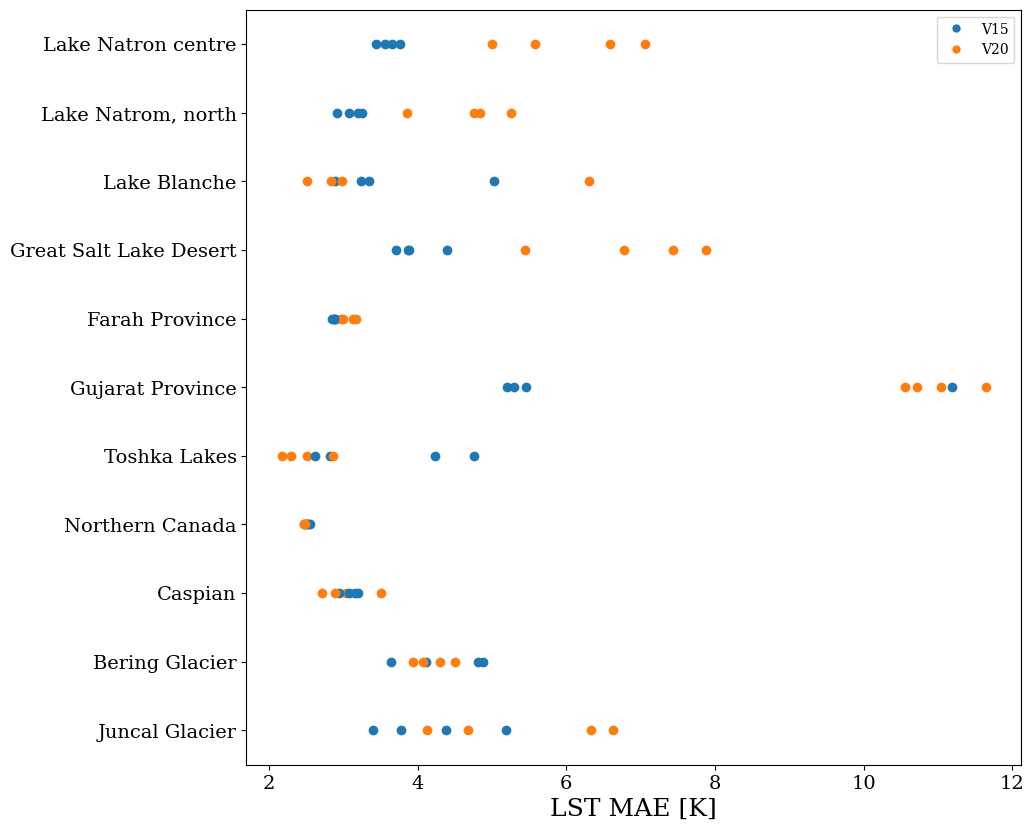

In [150]:
shift_plot(df_V15,df_V20,all_conditions,names,savefig="selected_points_shift_plot")

#### Global numbers for lakes 

In [231]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def RobinsonPlot(df,z,vmin,vmax,cmap,markersize,savefig,ncircles):


    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    x = df['latitude_ERA']
    y = df['longitude_ERA']
    z1 = df[z]
    
    
    #Normalise
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    #Colorbar
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal'
                               )
    #Scatter points
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    
    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(r'$\delta_{\rm V20}$ (K)',fontsize=34)
    

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    
    ax.scatter(180,0,c='1',transform=ccrs.PlateCarree(),s=100,alpha=0.1) #invisible point to set plot limits. Hacky, but works OK.
    ax.scatter(-180,0,c='1',transform=ccrs.PlateCarree(),s=100,alpha=0.1) #invisible point to set plot limits. Hacky, but works OK.

    #ax.scatter(180,0,c='k')

    #ax.set_xlim(-180,180)
    
    
    
    
    
    #Extra circles
    row = df.sort_values(by=['delta'],ascending=False).iloc[0:ncircles]
    xsel = row['latitude_ERA']
    ysel = row['longitude_ERA']
    
    sc_extra = ax.scatter(ysel,xsel,transform=ccrs.PlateCarree(),
                          s=200, facecolors='none', edgecolors='C2',lw=2
                          )

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    
    
    
    
    
    
    
    
    


In [257]:
df_V15['delta'] = df_V20['mean_error'] - df_V15['mean_error']

df_lake_v15    = df_V15.query(lake_condition)



In [243]:
n=10
df10 = df_lake_v15.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta']])

,latitude_ERA,longitude_ERA,delta
71526,24.028095,69.000000,4.209925
101073,41.170945,-113.400000,2.915094
38367,-2.388758,36.000000,2.449394
89077,34.145187,6.080000,2.197730
55693,13.067912,14.343750,1.738063
38705,-2.107728,36.000000,1.572047
100571,40.889915,-113.400000,1.270998
57099,14.192033,36.000000,0.934875
96882,38.641672,33.046875,0.850780
94958,37.517551,45.666667,0.815180


In [255]:
#0 - Gujarat
#1 - SLC
#2 -Lake Natron
#3 - Chott Felrhir 
#4 - Lake Chad
#5 - Lake Natron, other
#6 - SLC other
#7 - Sudan/Eritrea border 
#8 - Turkey - Tersakan Lake
#9 - Lake Urmia - Iran

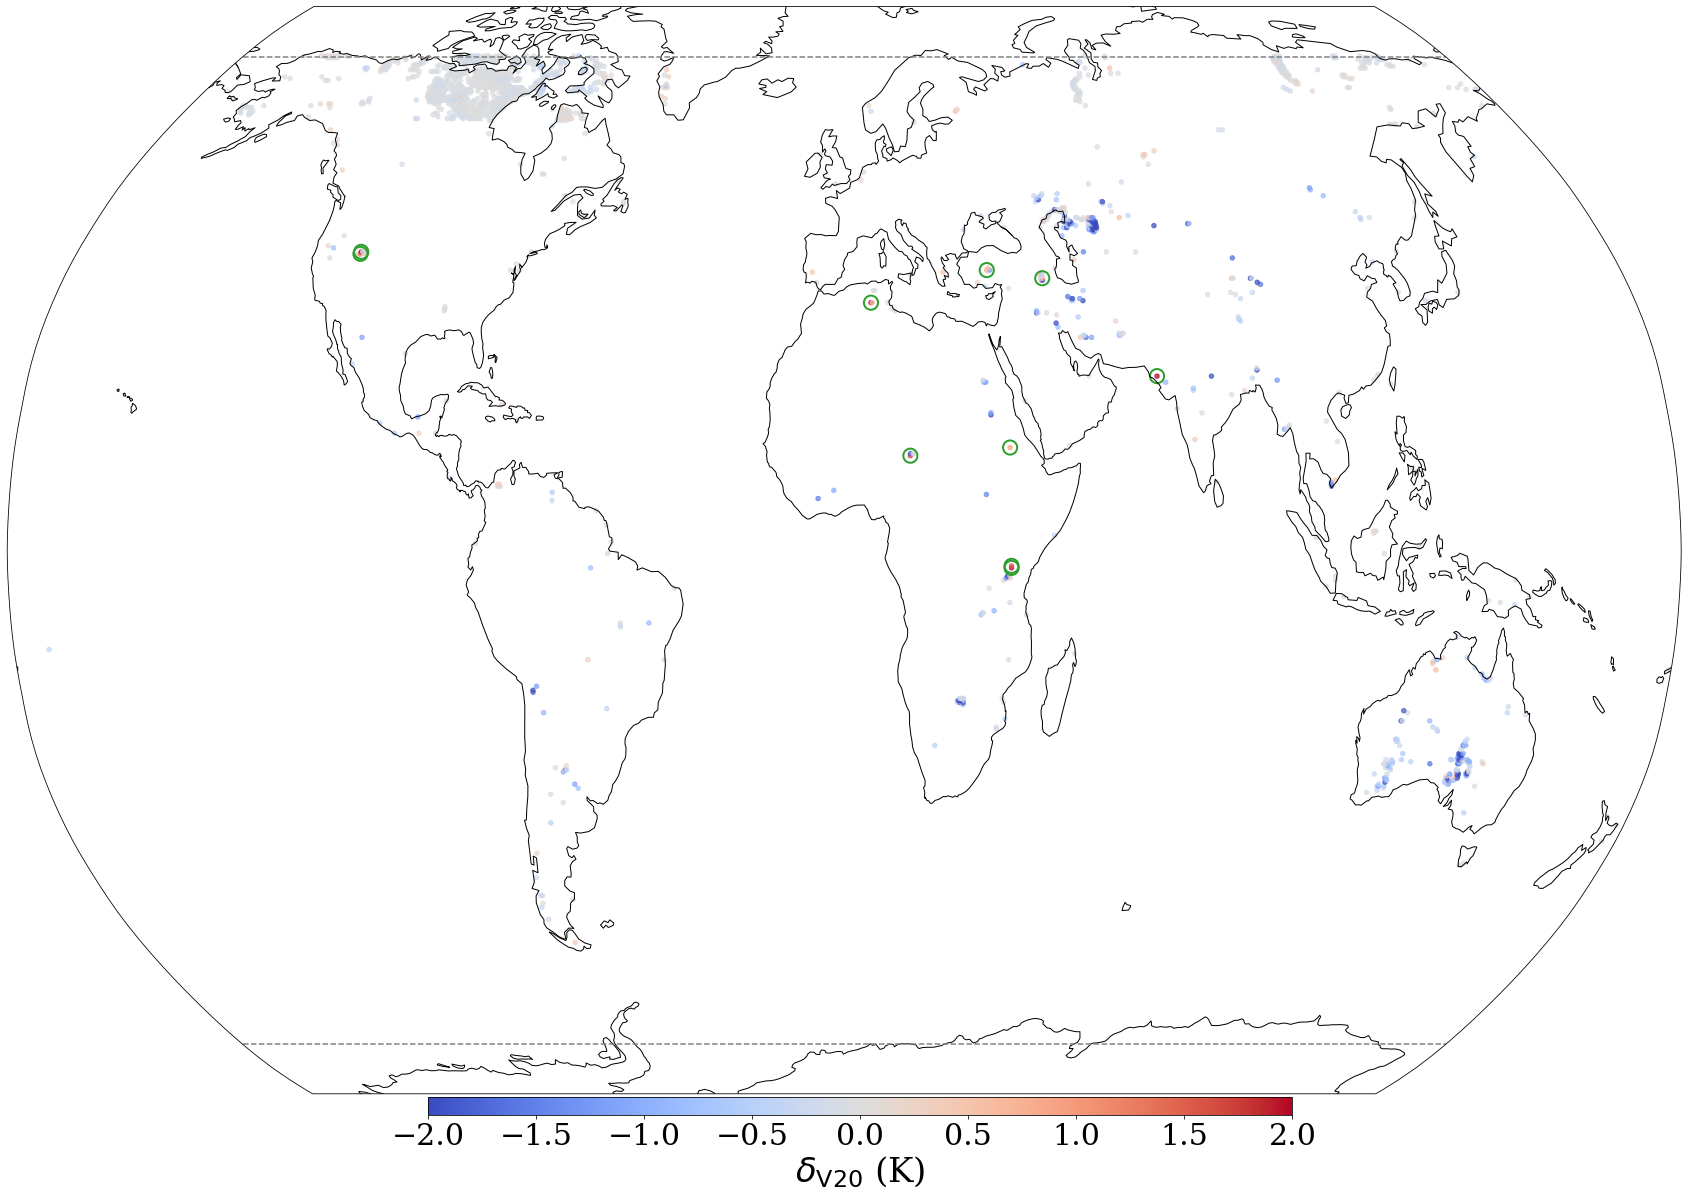

In [272]:
RobinsonPlot(df_lake_v15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='updated_lakes_plot',ncircles=n)


In [241]:
row = df_lake_v15.sort_values(by=['delta'],ascending=False).iloc[7]
display(row)
print("Coords:", row.latitude_ERA,row.longitude_ERA)


latitude_ERA                       14.192033
longitude_ERA                           36.0
MODIS_LST                          317.89328
prediction_error_1                  3.077289
prediction_1                      319.044617
prediction_error_2                  3.235154
prediction_2                      319.455475
prediction_error_3                  3.310555
prediction_3                      319.743317
prediction_error_4                  2.953996
prediction_4                      318.909058
V15_clFr                                 0.0
V15_cvhFr                           0.006622
V15_cvlFr                           0.989391
V15_dl                                  25.0
V15_oceanFr                              0.0
V15_si10Fr                               0.0
V15_z                            5123.824219
V20_clFr                            0.140967
V20_cvhFr                           0.005689
V20_cvlFr                           0.849909
V20_dl                                 150.0
V20_oceanF

Coords: 14.192033055763279 36.0


In [244]:
selected_latitudes = df10.latitude_ERA.to_numpy()
selected_longitudes = df10.longitude_ERA.to_numpy()

In [ ]:
new_conditions = []

for i in range(len(selected_latitudes)):
    c = f'latitude_ERA == {selected_latitudes[i]} & longitude_ERA == {selected_longitudes[i]}'
    new_conditions.extend([c])

['latitude_ERA == 24.028095261448925 & longitude_ERA == 69.0',
 'latitude_ERA == 41.17094491970063 & longitude_ERA == -113.39999999999998',
 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0',
 'latitude_ERA == 34.145187223212716 & longitude_ERA == 6.0800000000000125',
 'latitude_ERA == 13.067911638574962 & longitude_ERA == 14.34375',
 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0',
 'latitude_ERA == 40.88991462521181 & longitude_ERA == -113.39999999999998',
 'latitude_ERA == 14.192033055763279 & longitude_ERA == 36.0',
 'latitude_ERA == 38.64167222536426 & longitude_ERA == 33.046875',
 'latitude_ERA == 37.51755099834911 & longitude_ERA == 45.66666666666666']

In [253]:
i = 0



names = ['0 - Gujarat',
'1 - SLC',
'2 -Lake Natron',
'3 - Chott Felrhir', 
'4 - Lake Chad',
'5 - Lake Natron, other',
'6 - SLC other',
'7 - Sudan/Eritrea border',
'8 - Turkey - Tersakan Lake',
'9 - Lake Urmia - Iran',]







for c in new_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    
    
    
    

0 - Gujarat
Summary statistics: 1 || 2.544253 1.121596 0.416202 1.039276 || -1.255321 4.209924 5.242606
1 - SLC
Summary statistics: 1 || 0.259263 0.412639 0.919923 0.617111 || -0.182307 2.915094 0.247813
2 -Lake Natron
Summary statistics: 1 || 0.119602 1.478581 0.813442 0.532326 || 1.353858 2.449394 2.607876
3 - Chott Felrhir
Summary statistics: 1 || 0.410201 0.570298 0.489843 0.577912 || 0.340923 2.197729 0.725637
4 - Lake Chad
Summary statistics: 1 || 0.329502 1.212356 0.978455 0.959324 || 0.292141 1.738063 0.028727
5 - Lake Natron, other
Summary statistics: 1 || 0.128982 0.37359 0.511549 0.175062 || 0.717707 1.572047 1.235167
6 - SLC other
Summary statistics: 1 || 0.831902 0.605449 0.983131 0.072398 || 1.080558 1.270998 -0.933867
7 - Sudan/Eritrea border
Summary statistics: 1 || 0.138385 0.084107 0.287675 0.423933 || -0.239613 0.934875 1.062932
8 - Turkey - Tersakan Lake
Summary statistics: 1 || 0.254325 0.20083 0.340224 0.375462 || -0.002348 0.85078 0.994221
9 - Lake Urmia - Iran
S

In [269]:
new_names = ['Gujarat Province',
             'Great Salt Lake Desert',
             'Lake Natron centre',
             'Chott Felrhir', 
             'Lake Chad',
             'Lake Natron, north',
             'Al Fashaga',
             'Tersakan Lake',
             'Lake Urmia']




pop_conditions = new_conditions #.del[6]
del pop_conditions[6]

In [270]:
pop_conditions

['latitude_ERA == 24.028095261448925 & longitude_ERA == 69.0',
 'latitude_ERA == 41.17094491970063 & longitude_ERA == -113.39999999999998',
 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0',
 'latitude_ERA == 34.145187223212716 & longitude_ERA == 6.0800000000000125',
 'latitude_ERA == 13.067911638574962 & longitude_ERA == 14.34375',
 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0',
 'latitude_ERA == 38.64167222536426 & longitude_ERA == 33.046875',
 'latitude_ERA == 37.51755099834911 & longitude_ERA == 45.66666666666666']

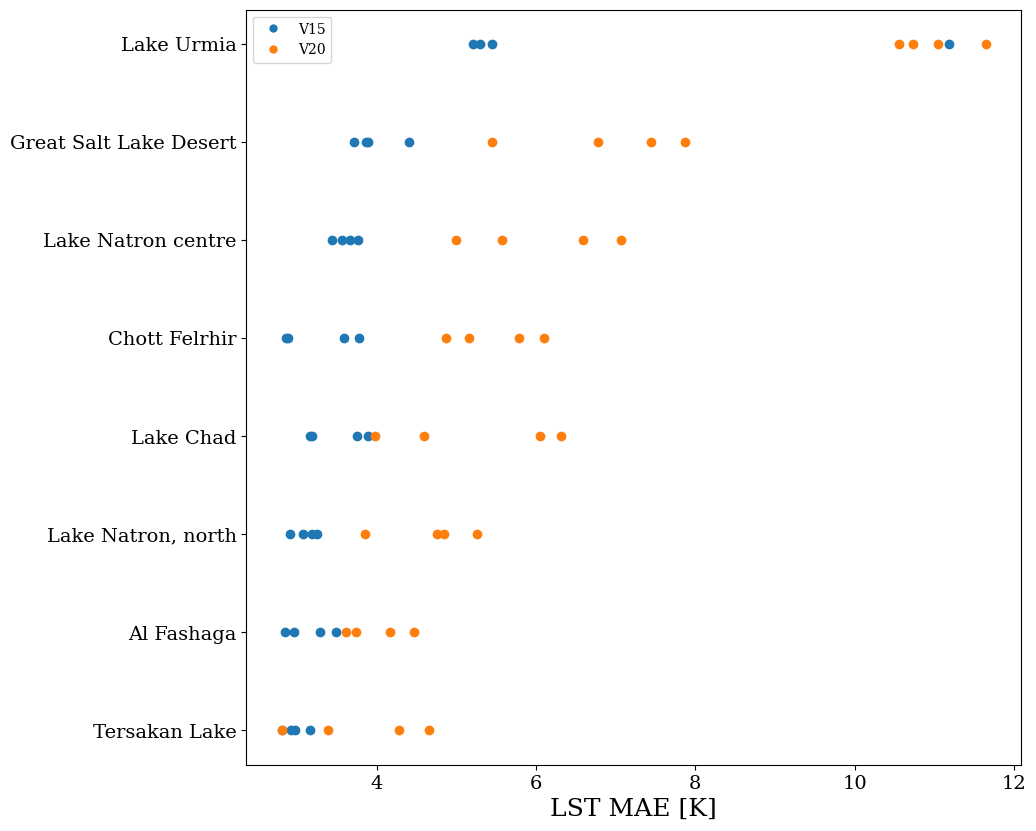

In [271]:
shift_plot(df_V15,df_V20,pop_conditions,new_names,savefig="selected_points_shift_plot_new")

### Glacier

In [259]:
df_glacier_v15 = df_V15.query(glacier_condition)
n=10
df10 = df_glacier_v15.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta']])

,latitude_ERA,longitude_ERA,delta
2328,-54.098337,-36.900000,2.573259
2797,-47.634641,-72.400000,2.494534
2632,-49.601853,68.750000,2.286490
2659,-49.320823,69.166667,1.970708
2119,-65.339540,-61.875000,1.683147
89218,34.145187,76.480000,1.638144
90646,34.988278,75.666667,1.547314
90163,34.707248,76.666667,1.475624
2174,-63.934391,-58.200000,1.459995
30091,-9.133487,-77.625000,1.388260


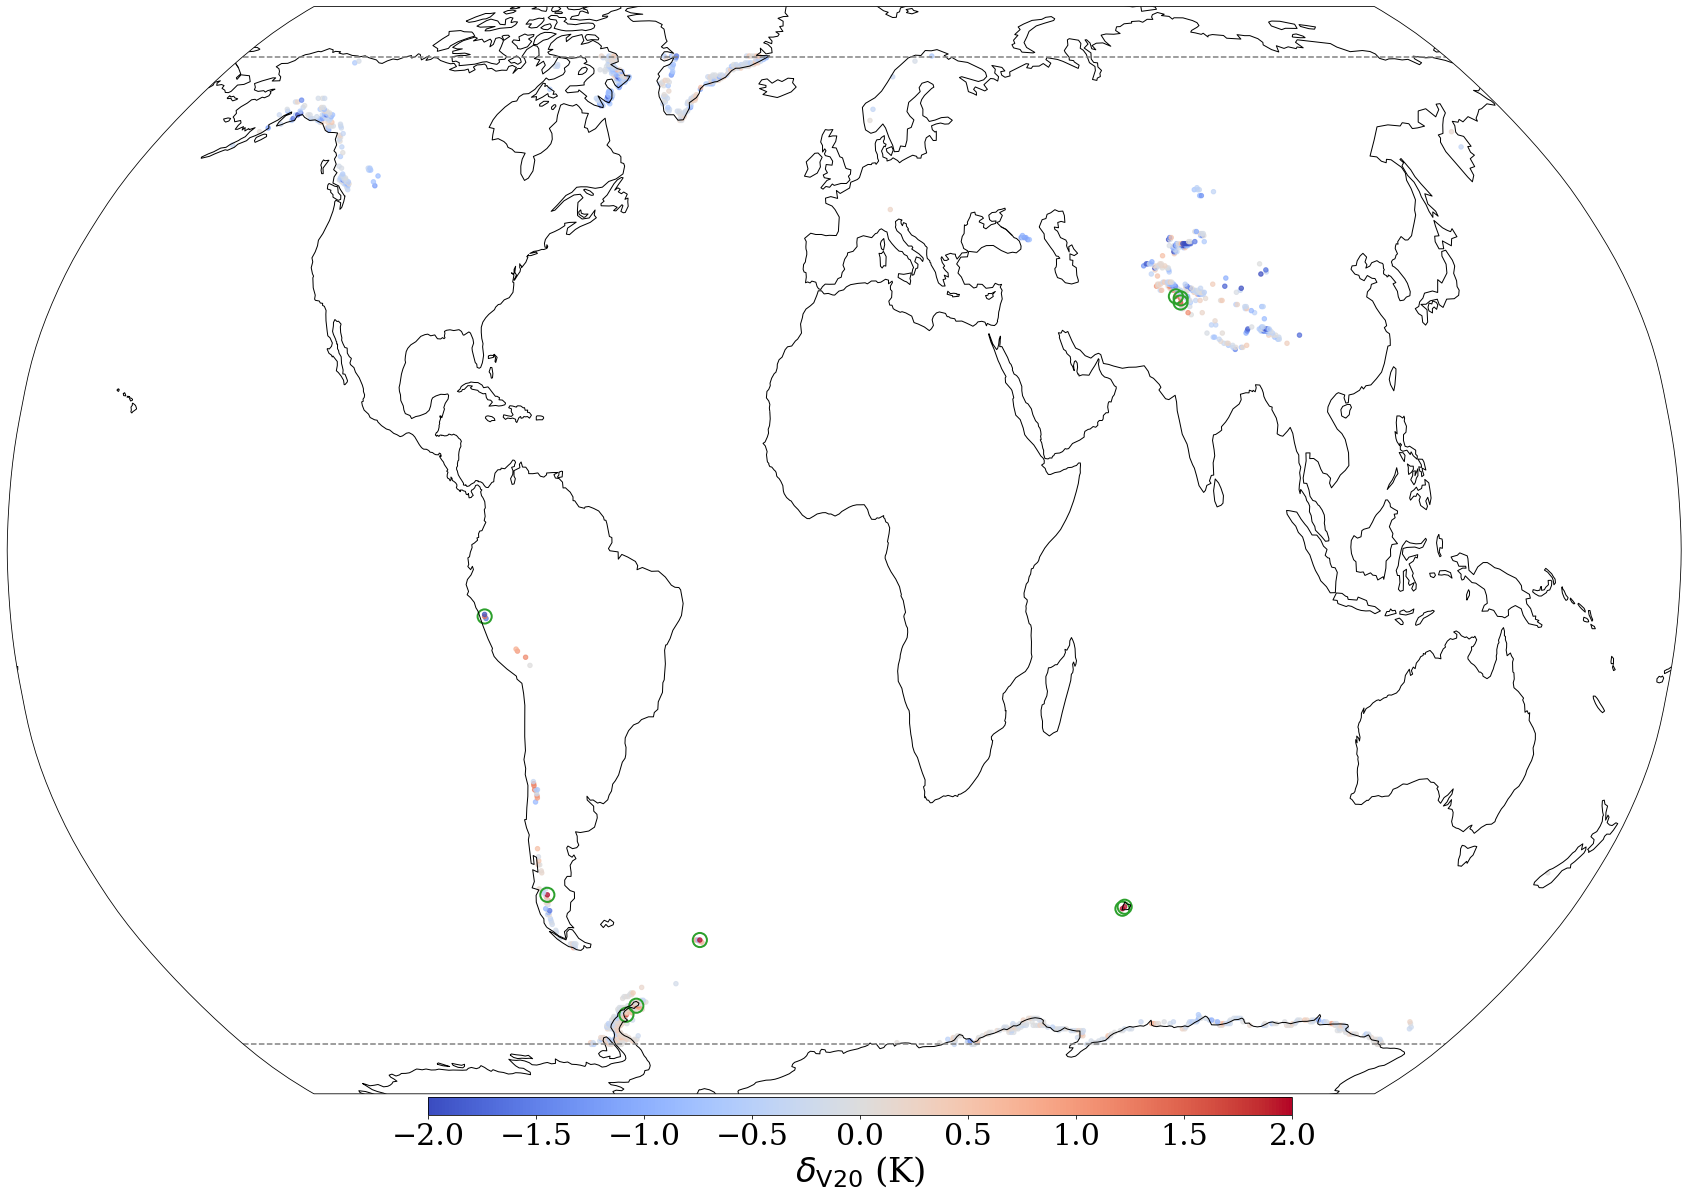

In [261]:
RobinsonPlot(df_glacier_v15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='updated_glacier_plot',ncircles=n)
